In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.13.0


In [7]:
base_dir = "F:\Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "Alzheimer_s Dataset"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [8]:
WORK_DIR = './Alzheimer_s Dataset'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [9]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


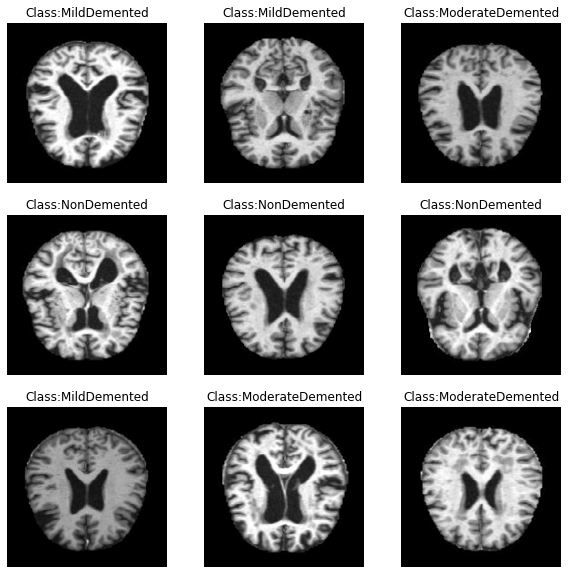

In [10]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [11]:
train_data, train_labels = train_data_gen.next()

In [12]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [13]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [14]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [15]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 27s 0us/step


In [16]:
for layer in inception_model.layers:
    layer.trainable=False

In [17]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [18]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# CALLBACKS = rop_callback
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)       

In [20]:
EPOCHS = 40

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/40
256/256 [==============================] - 7281s 28s/step - loss: 1.3545 - accuracy: 0.7456 - precision: 0.4851 - recall: 0.2872 - auc: 0.6907 - f1_score: 0.3595 - val_loss: 0.8268 - val_accuracy: 0.8253 - val_precision: 0.7586 - val_recall: 0.4419 - val_auc: 0.8698 - val_f1_score: 0.5549
Epoch 2/40
256/256 [==============================] - 231s 905ms/step - loss: 0.9100 - accuracy: 0.8102 - precision: 0.7043 - recall: 0.4147 - auc: 0.8467 - f1_score: 0.5204 - val_loss: 0.6777 - val_accuracy: 0.8474 - val_precision: 0.7964 - val_recall: 0.5234 - val_auc: 0.9139 - val_f1_score: 0.6298
Epoch 3/40
256/256 [==============================] - 217s 848ms/step - loss: 0.7929 - accuracy: 0.8312 - precision: 0.7544 - recall: 0.4814 - auc: 0.8845 - f1_score: 0.5862 - val_loss: 0.6204 - val_accuracy: 0.8585 - val_precision: 0.8164 - val_recall: 0.5601 - val_auc: 0.9286 - val_f1_score: 0.6628
Epoch 4/40
256/256 [==============================] - 222s 869ms/step - loss: 0.7176 - accuracy

KeyboardInterrupt: 

In [21]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 81s 1s/step - loss: 0.3013 - accuracy: 0.9425 - precision: 0.8922 - recall: 0.8758 - auc: 0.9839 - f1_score: 0.8838
Testing Accuracy: 94.25%


In [22]:
pred_labels = custom_inception_model.predict(test_data)

80/80 [==============================] - 62s 714ms/step


In [23]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.92      0.94      0.93       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.86      0.77      0.81       662
ModerateDemented       0.76      0.83      0.80       624

       micro avg       0.88      0.88      0.88      2560
       macro avg       0.88      0.88      0.88      2560
    weighted avg       0.88      0.88      0.88      2560
     samples avg       0.88      0.88      0.88      2560



In [24]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "inceptionV3.pkl"  
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(custom_inception_model, file)

ON ADNI Dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.13.0


In [3]:
WORK_DIR = './Alzheimers-ADNI'

CLASSES = [ 'Final AD JPEG', 'Final CN JPEG', 'Final EMCI JPEG', 'Final LMCI JPEG', 'Final MCI JPEG']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 1296 images belonging to 5 classes.


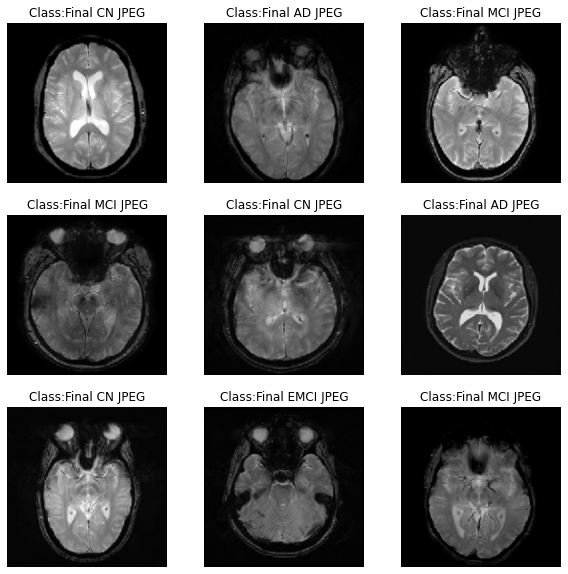

In [5]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3,4], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 1296)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:
print(train_data.shape, train_labels.shape)

(1296, 176, 176, 3) (1296, 5)


In [8]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(2900, 176, 176, 3) (2900, 5)


In [9]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [10]:
inceptionv3_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [11]:
for layer in inceptionv3_model.layers:
    layer.trainable=False

In [12]:
custom_inception_model = Sequential([
        inceptionv3_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(5, activation='softmax')        
    ], name = "inceptionv3_model")

In [13]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# CALLBACKS = rop_callback
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inceptionv3_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)         

In [15]:
EPOCHS = 15

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,steps_per_epoch=256)

Epoch 1/15
256/256 [==============================] - 71s 243ms/step - loss: 1.9879 - accuracy: 0.7563 - precision: 0.2323 - recall: 0.0947 - auc: 0.5191 - f1_score: 0.1284 - val_loss: 1.6312 - val_accuracy: 0.8004 - val_precision: 0.5556 - val_recall: 0.0108 - val_auc: 0.5615 - val_f1_score: 0.0237
Epoch 2/15
256/256 [==============================] - 65s 254ms/step - loss: 1.8167 - accuracy: 0.7778 - precision: 0.2621 - recall: 0.0610 - auc: 0.5341 - f1_score: 0.0907 - val_loss: 1.5533 - val_accuracy: 0.8000 - val_precision: 0.5000 - val_recall: 0.0043 - val_auc: 0.6123 - val_f1_score: 0.0080
Epoch 3/15
256/256 [==============================] - 65s 254ms/step - loss: 1.7125 - accuracy: 0.7882 - precision: 0.2510 - recall: 0.0298 - auc: 0.5491 - f1_score: 0.0491 - val_loss: 1.5595 - val_accuracy: 0.7991 - val_precision: 0.3750 - val_recall: 0.0065 - val_auc: 0.6115 - val_f1_score: 0.0159
Epoch 4/15
256/256 [==============================] - 76s 299ms/step - loss: 1.6547 - accuracy: 0

In [16]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

19/19 [==============================] - 13s 691ms/step - loss: 1.2722 - accuracy: 0.8217 - precision: 0.7203 - recall: 0.1776 - auc: 0.7833 - f1_score: 0.2673
Testing Accuracy: 82.17%


In [17]:
pred_labels = custom_inception_model.predict(test_data)

19/19 [==============================] - 16s 698ms/step


In [18]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                 precision    recall  f1-score   support

  Final AD JPEG       0.45      0.43      0.44       112
  Final CN JPEG       0.41      0.41      0.41       125
Final EMCI JPEG       0.37      0.38      0.37       117
Final LMCI JPEG       0.71      0.78      0.74       116
 Final MCI JPEG       0.38      0.35      0.37       110

      micro avg       0.47      0.47      0.47       580
      macro avg       0.46      0.47      0.47       580
   weighted avg       0.46      0.47      0.47       580
    samples avg       0.47      0.47      0.47       580



In [19]:
import pickle
# save the iris classification model as a pickle file
model_pkl_file = "inceptionv3Adni.pkl"  
with open(model_pkl_file, 'wb') as file:  
    pickle.dump(custom_inception_model, file)